In [1]:
import math
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import numpy as np

M_PI = 3.14159265358979


In [103]:
'''# 4 combo
propThrustFactor_x = -0.00014
propThrustFactor_y = -0.006
propThrustFactor_z = 5.6
maxRPM = 35000
propA = 3.3e-9
propTorqFactor = 0.0185
propInertia = 0.4e-05

motorKV = 3300.0
motorR = 0.11
motorI0 = 0.34

vbat = 16.8
'''

#''' # 5.1 race combo
propThrustFactor_x = -0.00014
propThrustFactor_y = -0.006
propThrustFactor_z = 19.0
maxRPM = 32000
propA = 9e-9
propTorqFactor = 0.03
propInertia = 0.00003

motorKV = 1900
motorR = 0.122
motorI0 = 0.34

vbat = 26.0
#'''

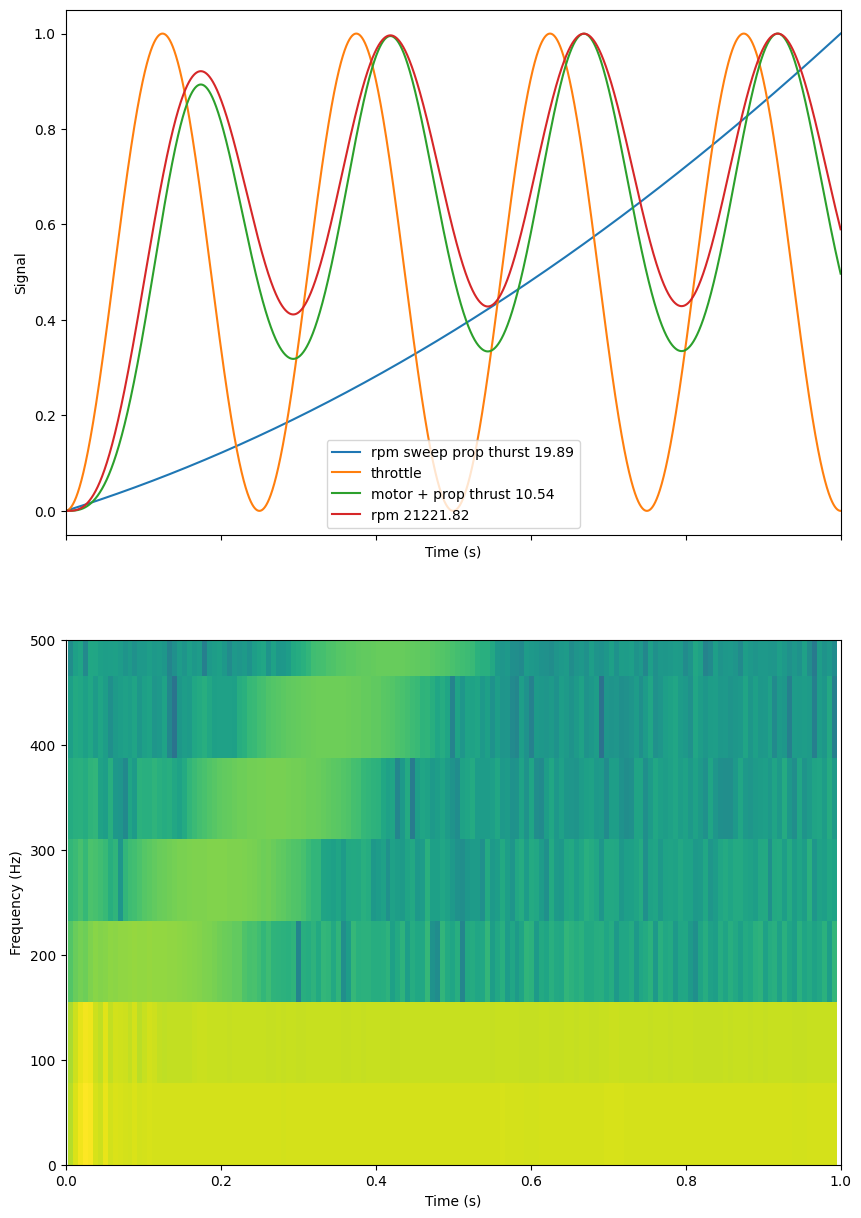

In [104]:
# calc & draw

def rpmToHz(rpm):
  return rpm / 60.0

def oscillation1f(amplitude, frequencyHz, t, phaseShift = 0):
  return amplitude * np.sin(2.0 * np.pi * frequencyHz * t + phaseShift)

def interpolate(x, y, i):
  return x * (1.0 - i) + y * i

output = 0.0

def lowpass(dt, cutoffFrequency, value):
  global output
  ePow = 1.0 - math.exp(-dt * 2.0 * math.pi * cutoffFrequency)
  output += (value - output) * ePow
  return output

def clamp(x, min, max):
  if (x < min):
    return min
  if (x > max):
    return max
  return x

def max(a, b):
  if(a > b):
    return a
  return b


def prop_thrust(rpm, vel):
  # max thrust vs velocity:
  propF = propThrustFactor_x * vel * vel + propThrustFactor_y * vel + propThrustFactor_z
  propF = max(0.0, propF)

  # thrust vs rpm (and max thrust)
  b = (propF - propA * maxRPM * maxRPM) / maxRPM
  result = b * rpm + propA * rpm * rpm

  return np.maximum(result, 0.0)

def prop_torque(rpm, vel):
  return prop_thrust(rpm, vel) * propTorqFactor

def motor_torque(volts, rpm):
  current = (volts - (rpm / motorKV)) / motorR

  if (current > 0):
    current = max(0.0, current - motorI0)
  elif (current < 0):
    current = min(0.0, current + motorI0)
  return current * 60 / (motorKV * 2.0 * M_PI)




current_rpm = 0

def rpmCurve(throttleArray):
  global current_rpm

  rpmList = []
  thrustList = []

  for throttleVal in np.nditer(throttleArray):
    pwm  = throttleVal * 1000.0 #+ 1000.0
    rpm = current_rpm

    volts = pwm / 1000.0 * vbat
    
    mtorque = motor_torque(volts, rpm)

    ptorque = prop_torque(rpm, 0)
    nettorque = mtorque - ptorque
    domega = nettorque / propInertia

    drpm = (domega * dt) * 60.0 / (2.0 * M_PI)

    maxdrpm = abs(volts * motorKV - rpm)
    rpm += clamp(drpm, -maxdrpm, maxdrpm)

    pthrust= prop_thrust(rpm, 0)

    current_rpm = rpm

    rpmList.append(rpm)
    thrustList.append(pthrust)
  
  return np.array(rpmList), np.array(thrustList)





# Fixing random state for reproducibility
np.random.seed(19680801)

frequency = 20e3
delta = 1e6 / frequency

dt = delta / 1e6

time = 1
maxRpmFull = 33000

t = np.arange(0.0, time, dt)

#throttle = np.linspace(0, 1, len(t))
throttle = oscillation1f(0.5, 4, t, -math.pi / 2) + 0.5
rpmFull = np.linspace(0, maxRpmFull, len(t))

s1x = oscillation1f(1.0, rpmToHz(rpmFull),t)

# add some noise into the mix
nse1 = 0.5 * np.random.random(size=len(t))
sig = s1x + nse1
x = np.vectorize(lowpass)(dt, 10, sig)




thrustZeroVel = prop_thrust(rpmFull, 0.0)
rpm, thrust = rpmCurve(throttle)


maxThrustZeroVel = np.max(thrustZeroVel)
maxThrust = np.max(thrust)
maxRpm = np.max(rpm)

thrustZeroVel = thrustZeroVel / maxThrustZeroVel
thrust = thrust / maxThrust
rpm = rpm / maxRpm


NFFT = 256  # the length of the windowing segments
Fs = 1/dt  # the sampling frequency

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(10, 15))
#ax1.plot(t, sig)
#ax1.plot(t, x)
ax1.plot(t, thrustZeroVel, label = 'rpm sweep prop thurst %.2f' % maxThrustZeroVel)
ax1.plot(t, throttle, label = 'throttle')
ax1.plot(t, thrust, label = 'motor + prop thrust %.2f' % maxThrust)
ax1.plot(t, rpm, label = 'rpm %.2f' % maxRpm)
ax1.legend()
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Signal')

Pxx, freqs, bins, im = ax2.specgram(x, NFFT=NFFT, Fs=Fs, mode='psd')
# The `specgram` method returns 4 objects. They are:
# - Pxx: the periodogram
# - freqs: the frequency vector
# - bins: the centers of the time bins
# - im: the .image.AxesImage instance representing the data in the plot
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Frequency (Hz)')
ax2.set_xlim(0, time)
ax2.set_ylim(0, 500)

plt.show()